# Predict Power generation #plant_1

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">navigation</h3>

* [1. Library](#1)
* [2. Data reading](#2)
* [3. Preprocessing](#3)
* [4. Identify Faulty SOURCE_KEY](#4)
* [5. Identify Faulty dust](#5)
* [6. Model build](#6)
* [7. Predict next two day generation](#7)


<a id="1"></a>

# Library

In [2]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split

<a id="2"></a>

# Data reading

In [3]:
plant_df = pd.read_csv("Plant_1_Generation_Data.csv")
plant_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [4]:
plant_df.shape

(68778, 7)

In [5]:
plant_df_columns = plant_df.columns.tolist()
plant_df[plant_df_columns].isnull().sum()

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

<a id="3"></a>

# Preprocessing

In [6]:
plant_df['DATE_TIME']= pd.to_datetime(plant_df['DATE_TIME'],format='%d-%m-%Y %H:%M') 

In [7]:
SOURCE_KEY_list = plant_df['SOURCE_KEY'].unique()
day_of_month_list = plant_df['DATE_TIME'].dt.day.unique()
month_list = plant_df['DATE_TIME'].dt.month.unique()

In [8]:
def data_collection():
    main_df = pd.DataFrame()
    for i in day_of_month_list:
        for j in month_list:
            df=plant_df[(plant_df.DATE_TIME.dt.month == j) & (plant_df.DATE_TIME.dt.day == i) ][-len(SOURCE_KEY_list):]
            df = df.drop(['PLANT_ID', 'DC_POWER', 'AC_POWER', 'TOTAL_YIELD'],axis = 1)
            df = df[df.DAILY_YIELD != 0]
            main_df = main_df.append(df, ignore_index=True)
    return main_df
main_df = data_collection()

In [9]:
main_df.index = main_df.DATE_TIME.dt.date.astype("datetime64[ns]")
main_df = main_df.drop(["DATE_TIME"],axis=1)

<a id="4"></a>

# Identify Faulty SOURCE_KEY

**Easily Identify faulty inverter side with graph of daily power generation.**

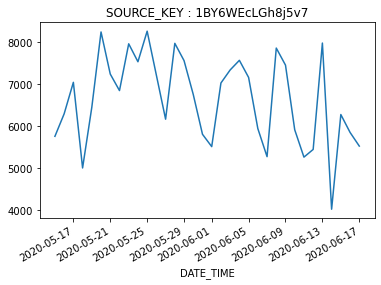

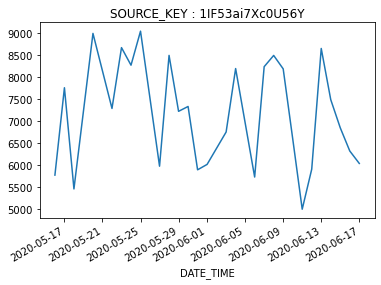

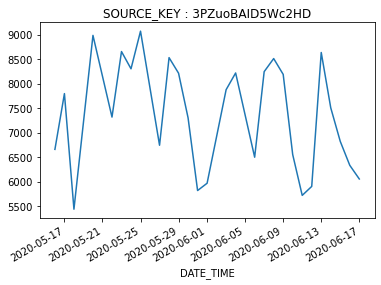

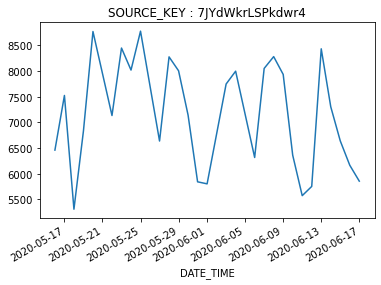

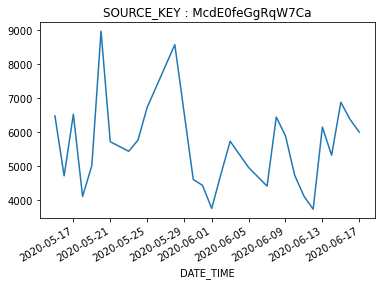

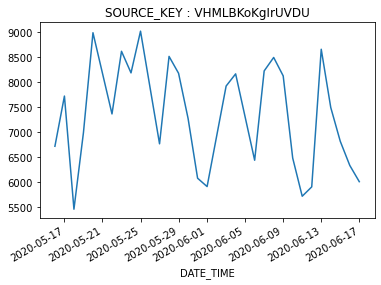

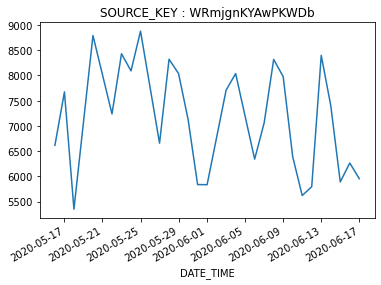

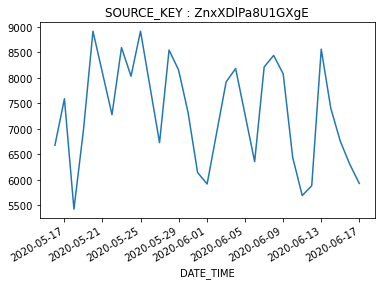

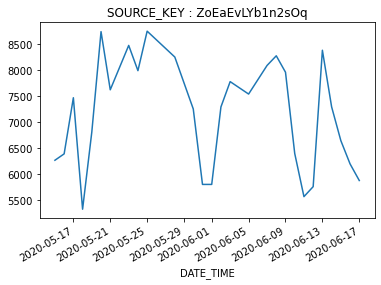

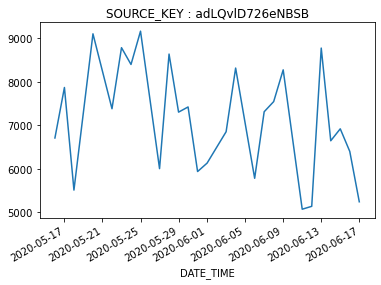

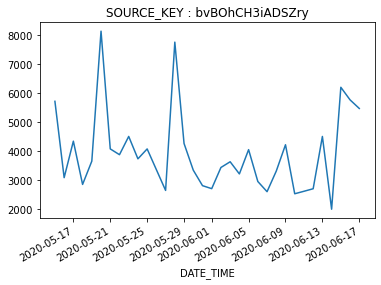

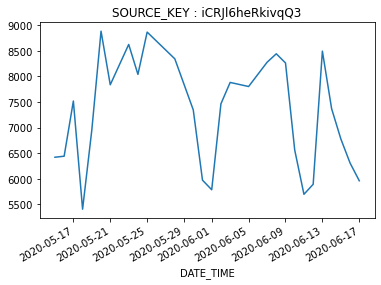

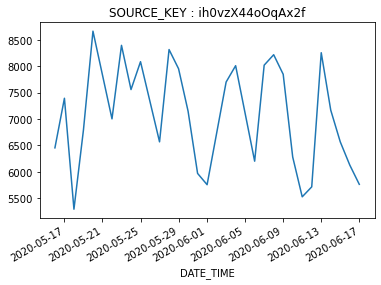

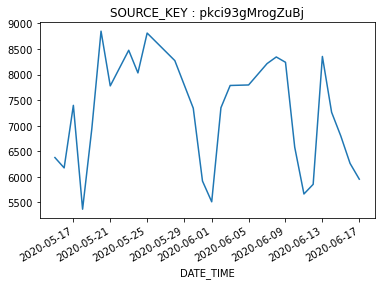

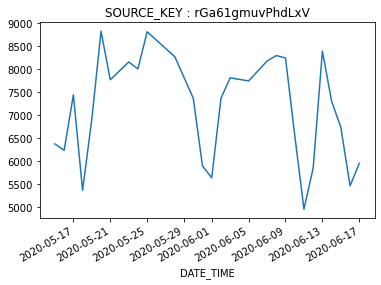

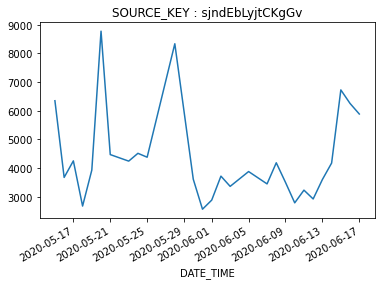

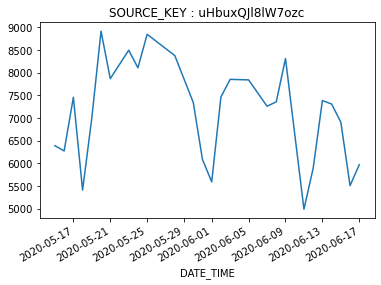

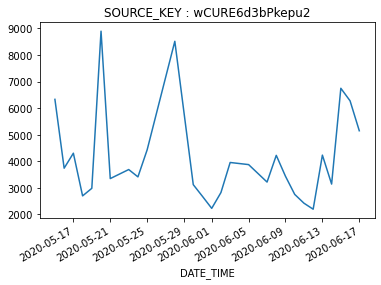

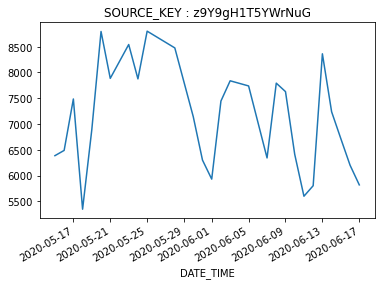

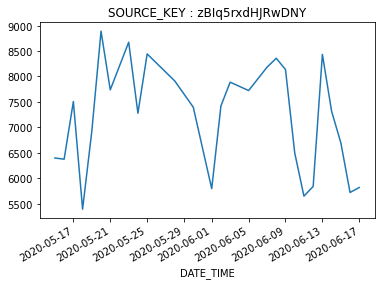

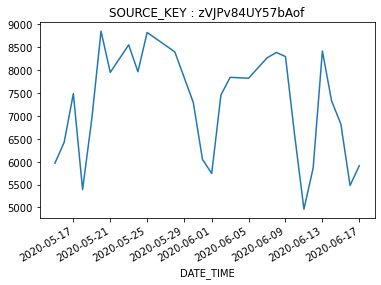

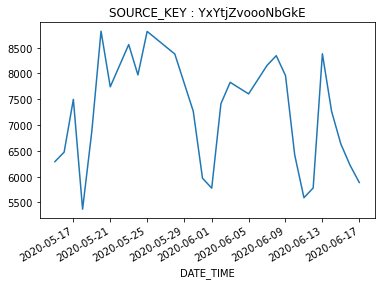

In [10]:
for i in SOURCE_KEY_list:
    df = main_df[main_df.SOURCE_KEY == i]
    df.DAILY_YIELD.plot()
    plt.title("SOURCE_KEY : %s"%i)
    plt.show()

**Can see some line suddenly drop down in below graph?**

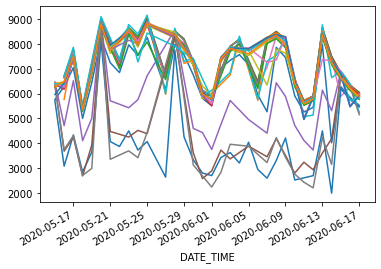

In [11]:

for i in SOURCE_KEY_list:
    df = main_df[main_df.SOURCE_KEY == i]
    df.DAILY_YIELD.plot()
plt.show()

This is faulty inverter ID list  (Fault_SOURCE_KEY_list)

In [12]:
Fault_SOURCE_KEY_list=  ["McdE0feGgRqW7Ca","bvBOhCH3iADSZry","sjndEbLyjtCKgGv","wCURE6d3bPkepu2"]

In [13]:
#remove data who having Fault_SOURCE_KEY_list in main_df
for i in Fault_SOURCE_KEY_list:
    main_df = main_df[main_df.SOURCE_KEY != i]

<a id="5"></a>

# Identify Faulty dust

in below graph just increase irregularities with time is some other faulty like DUST and others

<function matplotlib.pyplot.show(*args, **kw)>

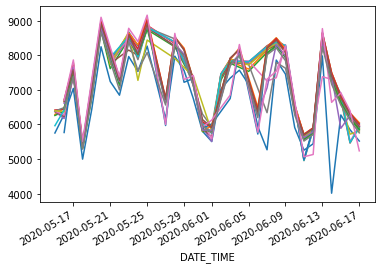

In [14]:
Unfault_SOURCE_KEY = main_df.SOURCE_KEY.unique()
for i in Unfault_SOURCE_KEY:
    df = main_df[main_df.SOURCE_KEY == i]
    df.DAILY_YIELD.plot()
plt.show

<a id="6"></a>

# Model build

In [15]:
main_df['dayofweek'] = main_df.index.dayofweek
main_df['quarter'] = main_df.index.quarter
main_df['month'] = main_df.index.month
main_df['year'] = main_df.index.year
main_df['dayofyear'] = main_df.index.dayofyear
main_df['dayofmonth'] = main_df.index.day
main_df['weekofyear'] = main_df.index.weekofyear

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


In [16]:
label_encoder = preprocessing.LabelEncoder() 
main_df['SOURCE_KEY']= label_encoder.fit_transform(main_df['SOURCE_KEY']) 
X = main_df[['SOURCE_KEY','dayofweek', 'quarter','month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y = main_df["DAILY_YIELD"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)

In [17]:
reg = xgb.XGBRegressor(n_estimators=500,
                       objective ='reg:squarederror',
                       learning_rate = 0.16,
                       colsample_bytree=0.6,
                       max_depth = 5,
                       min_child_weight = 6)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50)

[0]	validation_0-rmse:6078.51709	validation_1-rmse:6307.29297
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5129.43701	validation_1-rmse:5339.02539
[2]	validation_0-rmse:4340.27930	validation_1-rmse:4543.81006
[3]	validation_0-rmse:3681.84253	validation_1-rmse:3874.40503
[4]	validation_0-rmse:3119.12842	validation_1-rmse:3294.75391
[5]	validation_0-rmse:2647.10303	validation_1-rmse:2807.87134
[6]	validation_0-rmse:2249.78662	validation_1-rmse:2391.80200
[7]	validation_0-rmse:1917.22412	validation_1-rmse:2045.12097
[8]	validation_0-rmse:1651.19519	validation_1-rmse:1768.43323
[9]	validation_0-rmse:1431.93616	validation_1-rmse:1537.63501
[10]	validation_0-rmse:1224.38294	validation_1-rmse:1318.46655
[11]	validation_0-rmse:1057.16248	validation_1-rmse:1141.30786
[12]	validation_0-rmse:912.61914	validation_1-rmse:994.63245
[13]	validation_0-rmse:809.68079	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.16, max_delta_step=0, max_depth=5,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

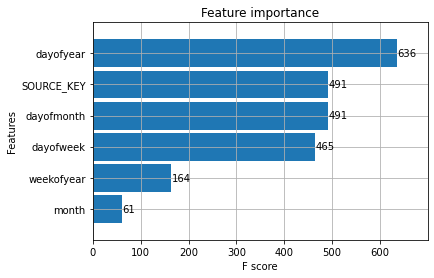

In [18]:
plot_importance(reg, height=0.9)

In [19]:
y_pred = reg.predict(X_test)
mean_squared_error(y_test,y_pred,squared=False)

219.4575196123908

<a id="7"></a>

# Predict next two day generation

this model is not effective for predict for greater then 5 days because of we have only 34 days data.

In [20]:
# n = number of days to predict future generation
def create_df(n):
    prediction_df = pd.DataFrame()
    for i in range(0,n):
        df = pd.DataFrame()
        df["SOURCE_KEY"] = Unfault_SOURCE_KEY
        df["DATE_TIME"] = "2020-06-%d"%(i+15)
        prediction_df = prediction_df.append(df)
    prediction_df['DATE_TIME']= pd.to_datetime(prediction_df['DATE_TIME']) 
    prediction_df.index = prediction_df.DATE_TIME.dt.date.astype("datetime64[ns]")
    prediction_df = prediction_df.drop(["DATE_TIME"],axis=1)
    prediction_df['dayofweek'] = prediction_df.index.dayofweek
    prediction_df['quarter'] = prediction_df.index.quarter
    prediction_df['month'] = prediction_df.index.month
    prediction_df['year'] = prediction_df.index.year
    prediction_df['dayofyear'] = prediction_df.index.dayofyear
    prediction_df['dayofmonth'] = prediction_df.index.day
    prediction_df['weekofyear'] = prediction_df.index.week
    return prediction_df
        

In [21]:
x = create_df(2)
df_copy = x.copy() 
x['SOURCE_KEY'] = label_encoder.fit_transform(x['SOURCE_KEY'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [22]:
y_prediction = reg.predict(x)

In [23]:
df_copy["DAILY_YIELD_prediction"] = y_prediction

In [24]:
df_copy

,SOURCE_KEY,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,DAILY_YIELD_prediction
DATE_TIME,,,,,,,,,
2020-06-15,1BY6WEcLGh8j5v7,0,2,6,2020,167,15,25,6070.666016
2020-06-15,YxYtjZvoooNbGkE,0,2,6,2020,167,15,25,6596.371582
2020-06-15,ZoEaEvLYb1n2sOq,0,2,6,2020,167,15,25,6654.264160
2020-06-15,iCRJl6heRkivqQ3,0,2,6,2020,167,15,25,6792.562988
2020-06-15,pkci93gMrogZuBj,0,2,6,2020,167,15,25,6791.932617
2020-06-15,rGa61gmuvPhdLxV,0,2,6,2020,167,15,25,6726.794922
2020-06-15,uHbuxQJl8lW7ozc,0,2,6,2020,167,15,25,6718.085938
2020-06-15,z9Y9gH1T5YWrNuG,0,2,6,2020,167,15,25,6751.519531
2020-06-15,zBIq5rxdHJRwDNY,0,2,6,2020,167,15,25,6736.009277


# Please comment for any idea to get improvment of model also, Write comment for mistakes